# Applying Yields and Resolutions

This notebook serves two purposes. The first is to act as a test; you should be able to reproduce the below graphic by running this notebook. The second is to serve as an example usecase. Below, we want to emulate a detector that we know follows either the Lindhard or Sorenson model for ionization energy and has a resolution that affects where the data lands; we are able to apply both the yields and resolutions to the data in order to get a more realistic model for the detector's output.

![SorVsLin_Ge.svg](SorVsLin_Ge.svg)

## Generating \*.root files for this notebook
The file used to generate the above plot for silicon is already present. However, if you would like to generate your own, you can replace it as follows. In the top-level nrCascadeSim directory, after compiling (and activating any necessary environments if applicable), run nrCascadeSim. An example command is below:
``` 
bin/realizeCascades -n 10000 -o example-usecase/data/Gefile.root levelfiles/v1_natGe_WFast.txt
```
You may change any arguments as you like. `-n 10000` tells the program to generate 10000 cascades. `-o example-usecase/data/Gefile.root` tells the program where to output the cascades; if you change this, you will either need to copy the file to this location or change the reference to the file in the first cell. `levelfiles/v1_natGe_Wfast.txt` selects the input file, which defines what cascades are possible and parameterizes them. The levelfile chosen allows any cascade known to occur in the isotope 28Si. (Note that due to the randomness of the output, some variation is expected if you replace the file.)

The files to generate the other three plots (for neon, argon, and silicon) are also present; if you wish to re-generate them, the appropriate levelfiles for these are `20ne_ngam.txt`, `40ar_ngam.txt`, and `Si28_ngam_all_cascades_rfmt_sorted.txt`, respectively.

## Important!
For best results, you should remove the pre-selected seed for this notebook. To remove the seeding for resolutions in this notebook, change the last line of the first cell from `seed = 1` to `seed = None`.
If you generate any of your own root files, you must remove the notebook seed.

## Notes

* You may encounter some runtime warnings - these are expected.  
* If you have a \*.root file you want to call saved to a different location than mentioned in the instructions above, be sure to change line 21 to point to the correct location.  
* Please allow sufficient time to run this notebook; for very large root files (millions or more data poins) it could take up to an hour. The provided file should only take a few minutes.
* The model parameters used were derived from Silicon data, but are assumed to apply to all elements. This is not a good physical assumption, but works fine for demonstrating the calculations.
* The scale on each plot is slightly different to help the visibility of the data.
* Values < 0 were removed. The resolution model generates a gaussian with a constant width, which is proportionately larger for smaller values of E, resulting in (non-physically) negative values in the results. 

In [1]:
#Setup

#"Standard" Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
plt.style.use('standard.mplstyle')
from matplotlib.lines import Line2D
#from hashlib import md5
#Custom libraries
import sys                   #Set up to import custom libraries
sys.path.append('./python')  #From `python` directory
from hist import histogramable as h #Custom library for applying yield models and formatting to use histogram function


retrieve = False #True #If you don't know what this does, you should probably leave it alone. For testing configuration only.
seed = 1 #None #You probably want to turn this to "None" if you're not interested in using specific seeds.

dict_keys(['xx', 'yy', 'ex', 'ey'])


In [2]:
#Build stuff!

#Select a file.
Gefile = './data/Gefile.root'

#You can change the scalefactor to alter the width of the resolution. 
#The number multiplies the width of the Gaussian,
#So a higher number will mean the resolution has more of an effect on the data.
resolution_scale = 0.2
#Apply yields and resolutions and format to display as histogram later.
try:
    real_Lind = [float(line[:-1]) for line in open('./data/Ge_real_Lind_s0.txt','r').readlines()]
    real_Sor = [float(line[:-1]) for line in open('./data/Ge_real_Sor_s0.txt','r').readlines()]
    small_Lind = [float(line[:-1]) for line in open('./data/Ge_small_Lind_s0.txt','r').readlines()]
    small_Sor = [float(line[:-1]) for line in open('./data/Ge_small_Sor_s0.txt','r').readlines()]
except FileNotFoundError:
    real_Lind = np.ndarray.flatten(np.asarray(h(Gefile,model='Lindhard',seed=seed)[0]))
    real_Sor = np.ndarray.flatten(np.asarray(h(Gefile,model='Sorensen',seed=seed)[0]))
    #This time, apply a (non-one) scale factor to the resolution models.
    small_Lind = np.ndarray.flatten(np.asarray(h(Gefile,model='Lindhard',material='Ge',scalefactor=resolution_scale,seed=seed)[0]))
    small_Sor = np.ndarray.flatten(np.asarray(h(Gefile,model='Sorensen',material='Ge',scalefactor=resolution_scale,seed=seed)[0]))

#Remove sub-zero energy readings (see explanation below graph)
real_Lind = [x for x in real_Lind if x >= 0]
real_Sor = [x for x in real_Sor if x >= 0]
small_Lind = [x for x in small_Lind if x >= 0]
small_Sor = [x for x in small_Sor if x >= 0]

#Define a function for formatting the y-axis ticks with scientific notation.
#From https://stackoverflow.com/questions/31517156/adjust-exponent-text-after-setting-scientific-limits-on-matplotlib-axis
def format_exponent(ax, axis='y'):

    # Change the ticklabel format to scientific format
    ax.ticklabel_format(axis=axis, style='sci', scilimits=(-2, 2))

    # Get the appropriate axis
    if axis == 'y':
        ax_axis = ax.yaxis
        x_pos = 0.0
        y_pos = 1.0
        horizontalalignment='left'
        verticalalignment='bottom'
    else:
        ax_axis = ax.xaxis
        x_pos = 1.0
        y_pos = -0.05
        horizontalalignment='right'
        verticalalignment='top'

    # Run plt.tight_layout() because otherwise the offset text doesn't update
    plt.tight_layout()

    # Get the offset value
    offset = ax_axis.get_offset_text().get_text()

    # If there's an offset,
    if len(offset) > 0:
        # Get that exponent value and change it into latex format
        minus_sign = u'\u2212'
        expo = float(offset.replace(minus_sign, '-').split('e')[-1])
        offset_text = r'x$\mathregular{10^{%d}}$' %expo

        # Turn off the offset text that's calculated automatically
        ax_axis.offsetText.set_visible(False)

        # Add in a text box at the top of the y axis
        ax.text(x_pos, y_pos, offset_text, transform=ax.transAxes,
               horizontalalignment=horizontalalignment,
               verticalalignment=verticalalignment,fontsize=30)
    return ax

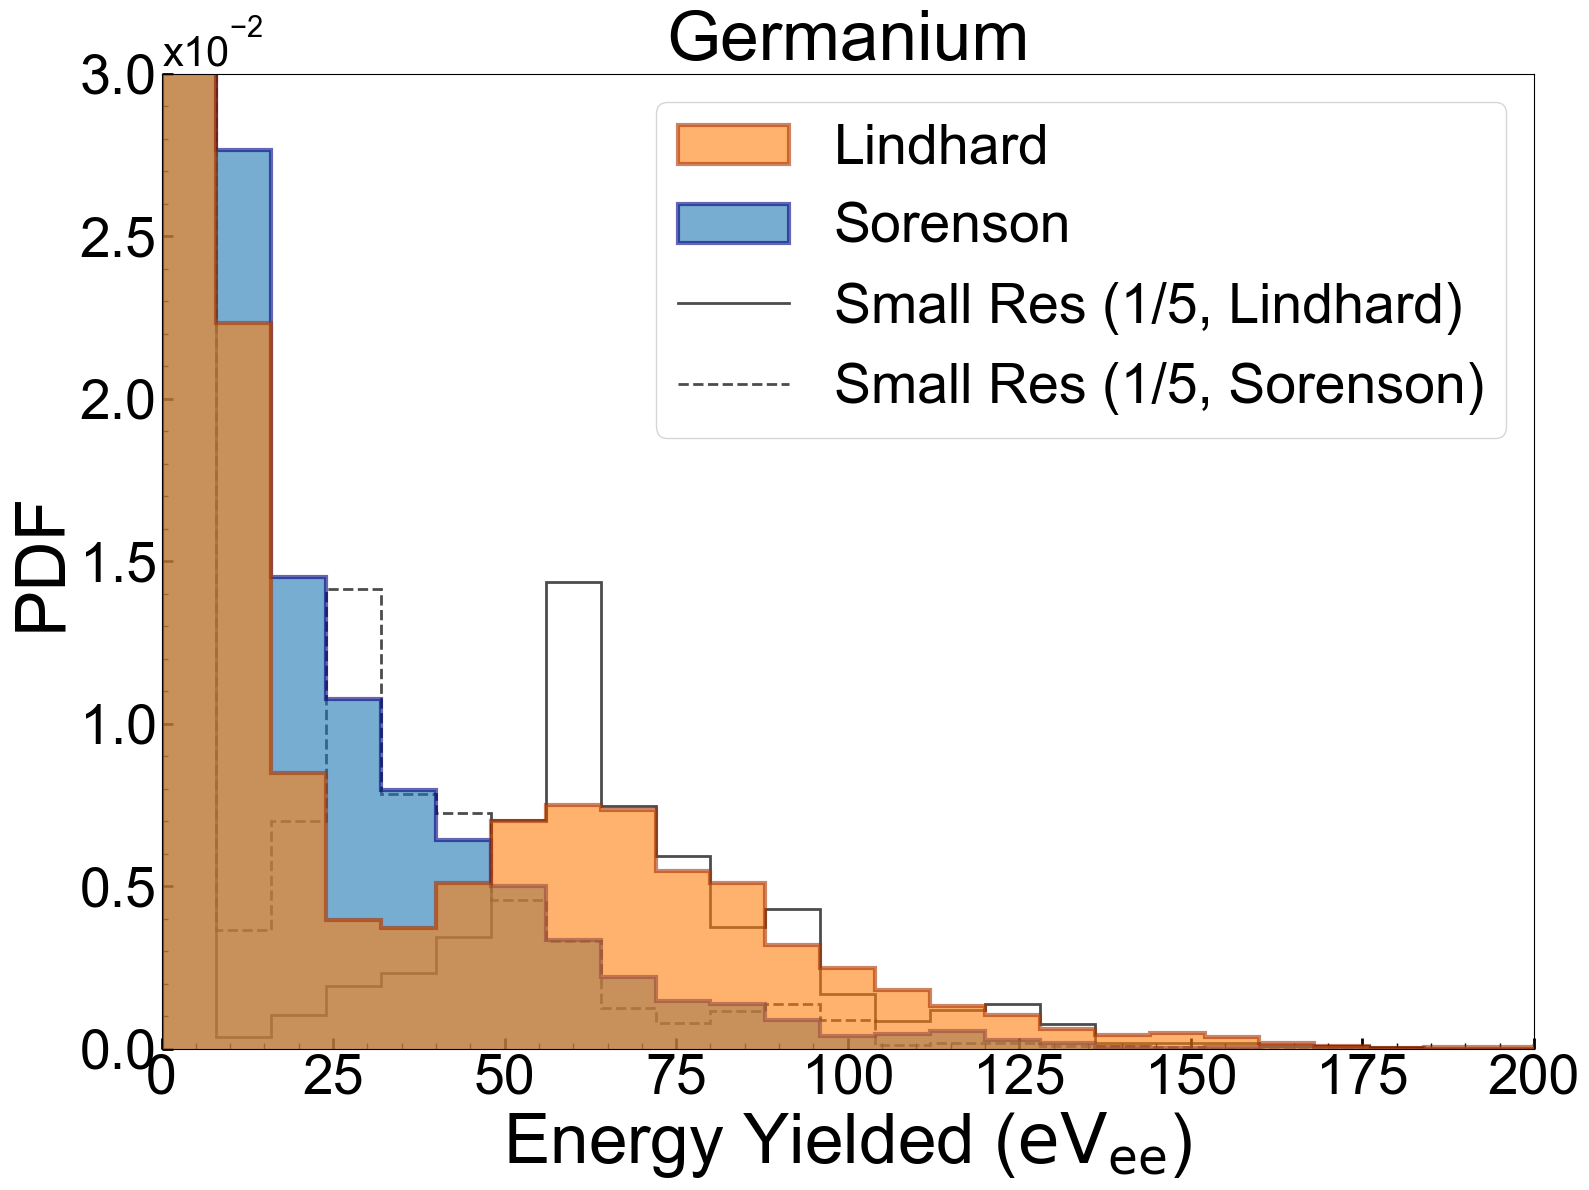

In [3]:
#Plotting!

#Set up to plot
fig, ax = plt.subplots(figsize=(16,12))

#Set up histogram binning.
binsize = 8 #bin width in eVee
bins = np.arange(0,620,binsize)

#Plot data
plt.hist(small_Lind,alpha=0.7,label='Small Res (1/5, Lindhard)',histtype='step',edgecolor='black',density='True',linewidth=2,bins=bins)
plt.hist(small_Sor,alpha=0.7,label='Small Res (1/5, Sorenson)',histtype='step',edgecolor='black',linestyle='--',density='True',linewidth=2,bins=bins)
plt.hist(real_Sor,alpha=0.6,label='Sorenson',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='navy',color='C0')
plt.hist(real_Lind,alpha=0.6,label='Lindhard',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='#a30',color='C1')

#Label Axes
plt.xlabel(r"Energy Yielded ($\mathrm{eV}_{\mathrm{ee}}$)",fontsize=50)
plt.ylabel("PDF",fontsize=50)#Counts/(total counts * bin width)")

#Format axis ticks
ax = format_exponent(ax, axis='y')
ax.tick_params(axis='both',which='major',labelsize=40)

#Define plotting region
plt.xlim([0,200])
plt.ylim([6e-13,3e-2]) #Make corner less awkward. Smallest starting value that will make the extra 0 go away

#Legend Formatting
LindPatch = mpatch.Patch(facecolor='C1',edgecolor='#a30',linewidth=3,label='Lindhard',alpha=0.6)
SorPatch = mpatch.Patch(facecolor='C0',edgecolor='navy',linewidth=3,label='Sorenson',alpha=0.6)
LindLine = Line2D([0],[0],alpha=0.7,color='black',label='Small Res (1/5, Lindhard)')
SorLine = Line2D([0],[0],linestyle='--',alpha=0.7,color='black',label='Small Res (1/5, Sorenson)')

#Display everything
plt.legend(handles=[LindPatch,SorPatch,LindLine,SorLine],fontsize=40)
plt.title('Germanium',fontsize=50)

plt.tight_layout()
#plt.savefig('SorVsLin_Ge.svg')
plt.show()

In [4]:
#Build stuff!

#Select a file.
Nefile = './data/Nefile.root'

#Apply yields and resolutions and format to display as histogram later.
#You can change the scalefactor to alter the width of the resolution. 
#The number multiplies the width of the Gaussian,
#So a higher number will mean the resolution has more of an effect on the data.
resolution_scale = 0.2
try:
    real_Lind = [float(line[:-1]) for line in open('./data/Ne_real_Lind_s0.txt','r').readlines()]
    real_Sor = [float(line[:-1]) for line in open('./data/Ne_real_Sor_s0.txt','r').readlines()]
    small_Lind = [float(line[:-1]) for line in open('./data/Ne_small_Lind_s0.txt','r').readlines()]
    small_Sor = [float(line[:-1]) for line in open('./data/Ne_small_Sor_s0.txt','r').readlines()]
except FileNotFoundError:
    real_Lind = np.ndarray.flatten(np.asarray(h(Nefile,model='Lindhard',seed=seed)[0]))
    real_Sor = np.ndarray.flatten(np.asarray(h(Nefile,model='Sorensen',seed=seed)[0]))
    #This time, apply a (non-one) scale factor to the resolution models.
    small_Lind = np.ndarray.flatten(np.asarray(h(Nefile,model='Lindhard',scalefactor=resolution_scale,seed=seed)[0]))
    small_Sor = np.ndarray.flatten(np.asarray(h(Nefile,model='Sorensen',scalefactor=resolution_scale,seed=seed)[0]))

#Remove sub-zero energy readings (see explanation below graph)
real_Lind = [x for x in real_Lind if x >= 0]
real_Sor = [x for x in real_Sor if x >= 0]
small_Lind = [x for x in small_Lind if x >= 0]
small_Sor = [x for x in small_Sor if x >= 0]

#Define a function for formatting the y-axis ticks with scientific notation.
#From https://stackoverflow.com/questions/31517156/adjust-exponent-text-after-setting-scientific-limits-on-matplotlib-axis
def format_exponent(ax, axis='y'):

    # Change the ticklabel format to scientific format
    ax.ticklabel_format(axis=axis, style='sci', scilimits=(-2, 2))

    # Get the appropriate axis
    if axis == 'y':
        ax_axis = ax.yaxis
        x_pos = 0.0
        y_pos = 1.0
        horizontalalignment='left'
        verticalalignment='bottom'
    else:
        ax_axis = ax.xaxis
        x_pos = 1.0
        y_pos = -0.05
        horizontalalignment='right'
        verticalalignment='top'

    # Run plt.tight_layout() because otherwise the offset text doesn't update
    plt.tight_layout()

    # Get the offset value
    offset = ax_axis.get_offset_text().get_text()

    # If there's an offset,
    if len(offset) > 0:
        # Get that exponent value and change it into latex format
        minus_sign = u'\u2212'
        expo = float(offset.replace(minus_sign, '-').split('e')[-1])
        offset_text = r'x$\mathregular{10^{%d}}$' %expo

        # Turn off the offset text that's calculated automatically
        ax_axis.offsetText.set_visible(False)

        # Add in a text box at the top of the y axis
        ax.text(x_pos, y_pos, offset_text, transform=ax.transAxes,
               horizontalalignment=horizontalalignment,
               verticalalignment=verticalalignment,fontsize=30)
    return ax

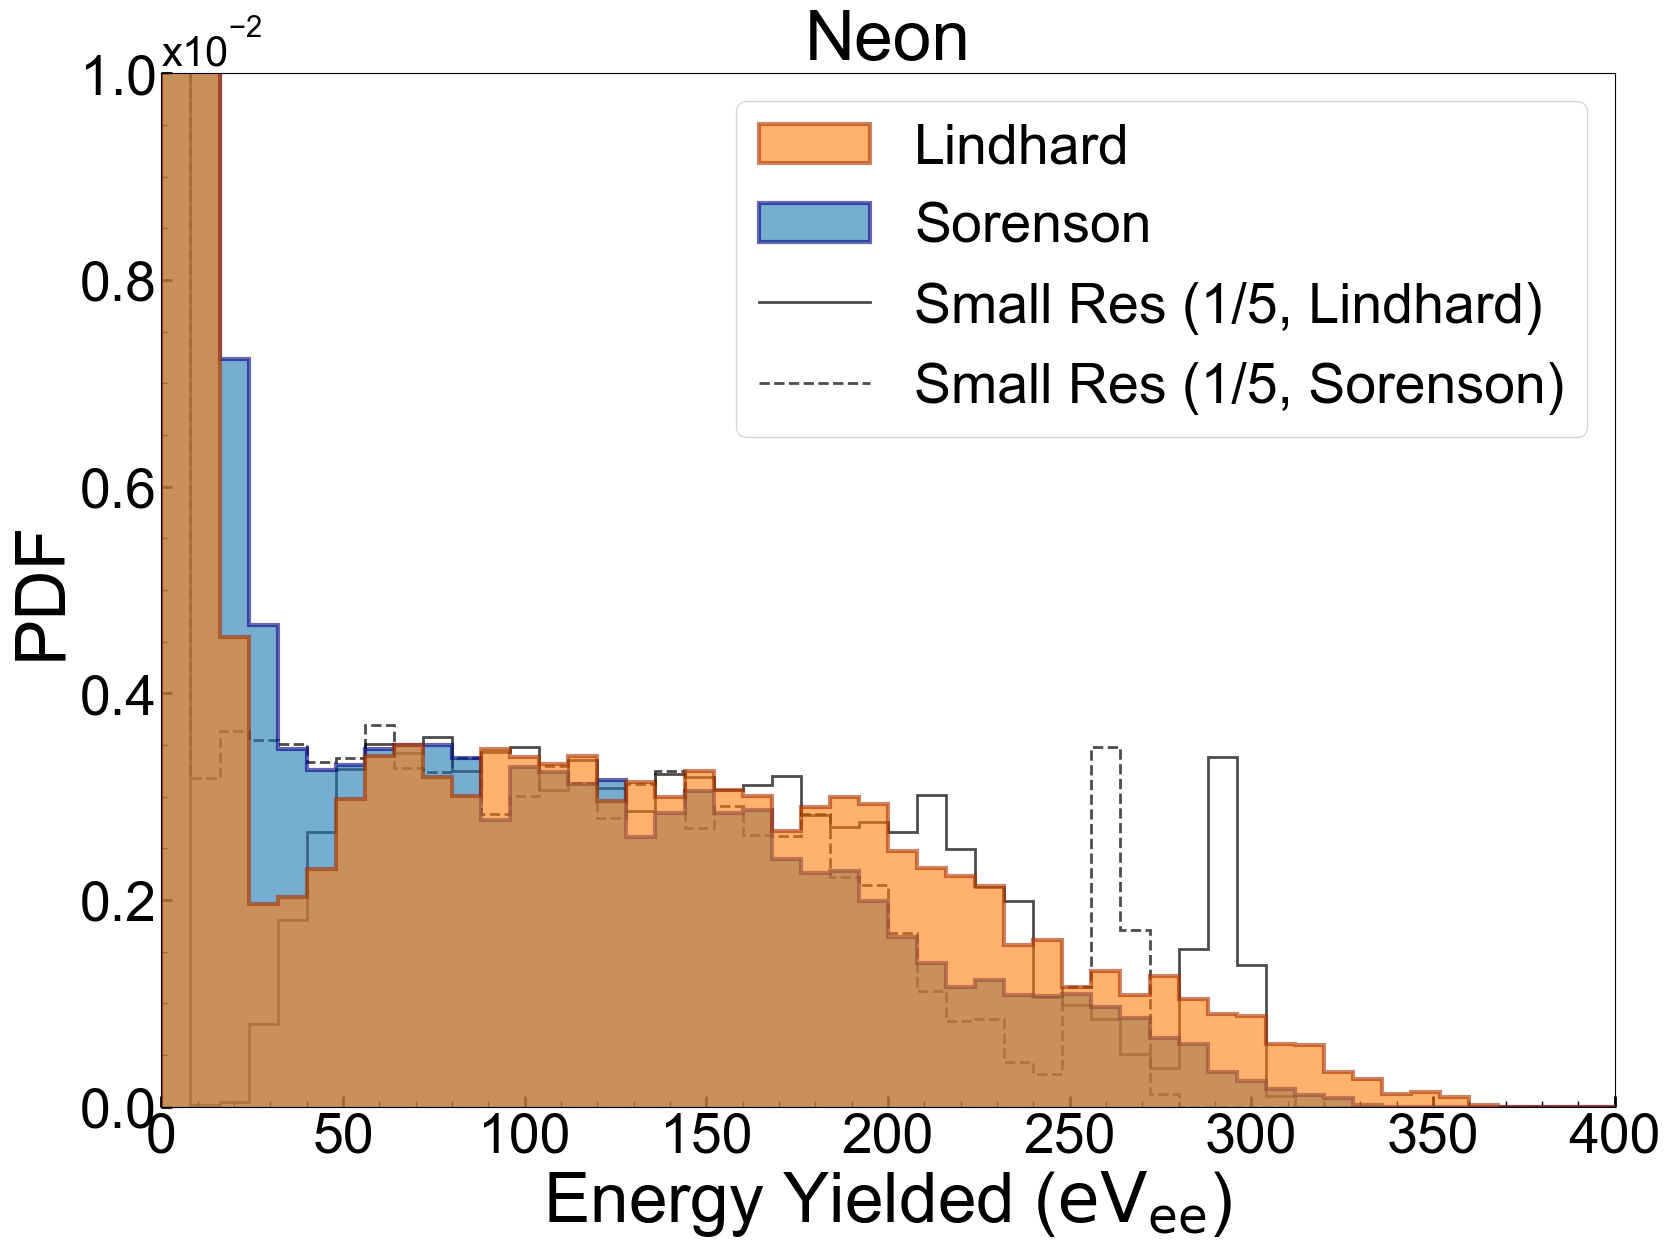

In [5]:
#Plotting!

#Set up to plot
fig, ax = plt.subplots(figsize=(16,12))

#Set up histogram binning.
binsize = 8 #bin width in eVee
bins = np.arange(0,620,binsize)

#Plot data
plt.hist(small_Lind,alpha=0.7,label='Small Res (1/5, Lindhard)',histtype='step',edgecolor='black',density='True',linewidth=2,bins=bins)
plt.hist(small_Sor,alpha=0.7,label='Small Res (1/5, Sorenson)',histtype='step',edgecolor='black',linestyle='--',density='True',linewidth=2,bins=bins)
plt.hist(real_Sor,alpha=0.6,label='Sorenson',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='navy',color='C0')
plt.hist(real_Lind,alpha=0.6,label='Lindhard',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='#a30',color='C1')

#Label Axes
plt.xlabel(r"Energy Yielded ($\mathrm{eV}_{\mathrm{ee}}$)",fontsize=50)
plt.ylabel("PDF",fontsize=50)#Counts/(total counts * bin width)")

#Format axis ticks
ax = format_exponent(ax, axis='y')
ax.tick_params(axis='both',which='major',labelsize=40)

#Define plotting region
plt.xlim([0,400])
plt.ylim([6e-13,1e-2]) #Make corner less awkward. Smallest starting value that will make the extra 0 go away

#Legend Formatting
LindPatch = mpatch.Patch(facecolor='C1',edgecolor='#a30',linewidth=3,label='Lindhard',alpha=0.6)
SorPatch = mpatch.Patch(facecolor='C0',edgecolor='navy',linewidth=3,label='Sorenson',alpha=0.6)
LindLine = Line2D([0],[0],alpha=0.7,color='black',label='Small Res (1/5, Lindhard)')
SorLine = Line2D([0],[0],linestyle='--',alpha=0.7,color='black',label='Small Res (1/5, Sorenson)')

#Display everything
plt.legend(handles=[LindPatch,SorPatch,LindLine,SorLine],fontsize=40)
plt.title('Neon',fontsize=50)
plt.show()

In [6]:
#Build stuff!

#Select a file.
Arfile = './data/Arfile.root'

#You can change the scalefactor to alter the width of the resolution. 
#The number multiplies the width of the Gaussian,
#So a higher number will mean the resolution has more of an effect on the data.
resolution_scale = 0.2
#Apply yields and resolutions and format to display as histogram later.
try:
    real_Lind = [float(line[:-1]) for line in open('./data/Ar_real_Lind_s0.txt','r').readlines()]
    real_Sor = [float(line[:-1]) for line in open('./data/Ar_real_Sor_s0.txt','r').readlines()]
    small_Lind = [float(line[:-1]) for line in open('./data/Ar_small_Lind_s0.txt','r').readlines()]
    small_Sor = [float(line[:-1]) for line in open('./data/Ar_small_Sor_s0.txt','r').readlines()]
except FileNotFoundError:
    real_Lind = np.ndarray.flatten(np.asarray(h(Arfile,model='Lindhard',seed=seed)[0]))
    real_Sor = np.ndarray.flatten(np.asarray(h(Arfile,model='Sorensen',seed=seed)[0]))
    #This time, apply a (non-one) scale factor to the resolution models.
    small_Lind = np.ndarray.flatten(np.asarray(h(Arfile,model='Lindhard',scalefactor=resolution_scale,seed=seed)[0]))
    small_Sor = np.ndarray.flatten(np.asarray(h(Arfile,model='Sorensen',scalefactor=resolution_scale,seed=seed)[0]))

#Remove sub-zero energy readings (see explanation below graph)
real_Lind = [x for x in real_Lind if x >= 0]
real_Sor = [x for x in real_Sor if x >= 0]
small_Lind = [x for x in small_Lind if x >= 0]
small_Sor = [x for x in small_Sor if x >= 0]

#Define a function for formatting the y-axis ticks with scientific notation.
#From https://stackoverflow.com/questions/31517156/adjust-exponent-text-after-setting-scientific-limits-on-matplotlib-axis
def format_exponent(ax, axis='y'):

    # Change the ticklabel format to scientific format
    ax.ticklabel_format(axis=axis, style='sci', scilimits=(-2, 2))

    # Get the appropriate axis
    if axis == 'y':
        ax_axis = ax.yaxis
        x_pos = 0.0
        y_pos = 1.0
        horizontalalignment='left'
        verticalalignment='bottom'
    else:
        ax_axis = ax.xaxis
        x_pos = 1.0
        y_pos = -0.05
        horizontalalignment='right'
        verticalalignment='top'

    # Run plt.tight_layout() because otherwise the offset text doesn't update
    plt.tight_layout()

    # Get the offset value
    offset = ax_axis.get_offset_text().get_text()

    # If there's an offset,
    if len(offset) > 0:
        # Get that exponent value and change it into latex format
        minus_sign = u'\u2212'
        expo = float(offset.replace(minus_sign, '-').split('e')[-1])
        offset_text = r'x$\mathregular{10^{%d}}$' %expo

        # Turn off the offset text that's calculated automatically
        ax_axis.offsetText.set_visible(False)

        # Add in a text box at the top of the y axis
        ax.text(x_pos, y_pos, offset_text, transform=ax.transAxes,
               horizontalalignment=horizontalalignment,
               verticalalignment=verticalalignment,fontsize=30)
    return ax

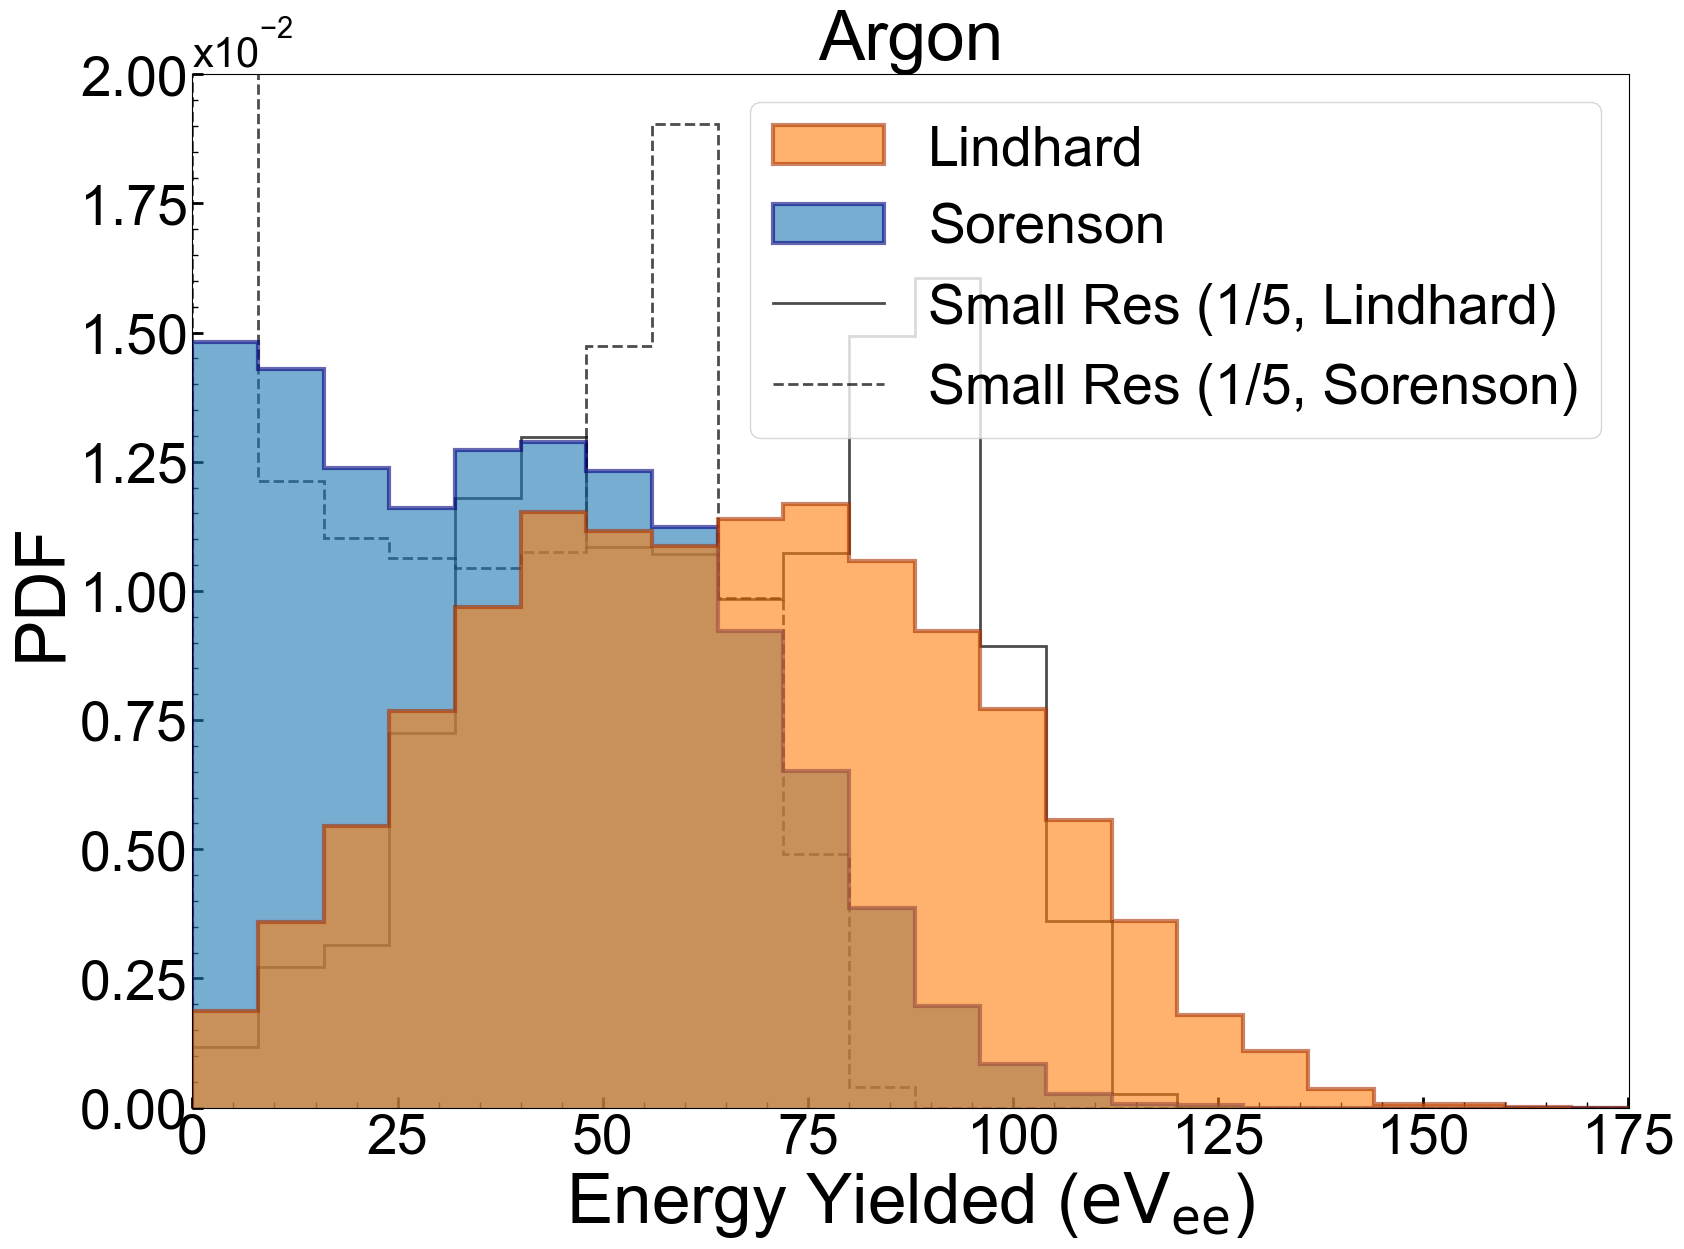

In [7]:
#Plotting!

#Set up to plot
fig, ax = plt.subplots(figsize=(16,12))

#Set up histogram binning.
binsize = 8 #bin width in eVee
bins = np.arange(0,620,binsize)

#Plot data
plt.hist(small_Lind,alpha=0.7,label='Small Res (1/5, Lindhard)',histtype='step',edgecolor='black',density='True',linewidth=2,bins=bins)
plt.hist(small_Sor,alpha=0.7,label='Small Res (1/5, Sorenson)',histtype='step',edgecolor='black',linestyle='--',density='True',linewidth=2,bins=bins)
plt.hist(real_Sor,alpha=0.6,label='Sorenson',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='navy',color='C0')
plt.hist(real_Lind,alpha=0.6,label='Lindhard',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='#a30',color='C1')

#Label Axes
plt.xlabel(r"Energy Yielded ($\mathrm{eV}_{\mathrm{ee}}$)",fontsize=50)
plt.ylabel("PDF",fontsize=50)#Counts/(total counts * bin width)")

#Format axis ticks
ax = format_exponent(ax, axis='y')
ax.tick_params(axis='both',which='major',labelsize=40)

#Define plotting region
plt.xlim([0,175])
plt.ylim([6e-13,2e-2]) #Make corner less awkward. Smallest starting value that will make the extra 0 go away

#Legend Formatting
LindPatch = mpatch.Patch(facecolor='C1',edgecolor='#a30',linewidth=3,label='Lindhard',alpha=0.6)
SorPatch = mpatch.Patch(facecolor='C0',edgecolor='navy',linewidth=3,label='Sorenson',alpha=0.6)
LindLine = Line2D([0],[0],alpha=0.7,color='black',label='Small Res (1/5, Lindhard)')
SorLine = Line2D([0],[0],linestyle='--',alpha=0.7,color='black',label='Small Res (1/5, Sorenson)')

#Display everything
plt.legend(handles=[LindPatch,SorPatch,LindLine,SorLine],fontsize=40)
plt.title('Argon',fontsize=50)
plt.show()

In [8]:
#Build stuff!

#Select a file.
Sifile = './data/Sifile.root'

#Apply yields and resolutions and format to display as histogram later.
#You can change the scalefactor to alter the width of the resolution. 
#The number multiplies the width of the Gaussian,
#So a higher number will mean the resolution has more of an effect on the data.
resolution_scale = 0.2
try:
    real_Lind = [float(line[:-1]) for line in open('./data/Si_real_Lind_s0.txt','r').readlines()]
    real_Sor = [float(line[:-1]) for line in open('./data/Si_real_Sor_s0.txt','r').readlines()]
    small_Lind = [float(line[:-1]) for line in open('./data/Si_small_Lind_s0.txt','r').readlines()]
    small_Sor = [float(line[:-1]) for line in open('./data/Si_small_Sor_s0.txt','r').readlines()]
except FileNotFoundError:
    real_Lind = np.ndarray.flatten(np.asarray(h(Sifile,model='Lindhard',seed=seed)[0]))
    real_Sor = np.ndarray.flatten(np.asarray(h(Sifile,model='Sorensen',seed=seed)[0]))
    #This time, apply a (non-one) scale factor to the resolution models.
    small_Lind = np.ndarray.flatten(np.asarray(h(Sifile,model='Lindhard',scalefactor=resolution_scale,seed=seed)[0]))
    small_Sor = np.ndarray.flatten(np.asarray(h(Sifile,model='Sorensen',scalefactor=resolution_scale,seed=seed)[0]))

#Remove sub-zero energy readings (see explanation below graph)
real_Lind = [x for x in real_Lind if x >= 0]
real_Sor = [x for x in real_Sor if x >= 0]
small_Lind = [x for x in small_Lind if x >= 0]
small_Sor = [x for x in small_Sor if x >= 0]

#Define a function for formatting the y-axis ticks with scientific notation.
#From https://stackoverflow.com/questions/31517156/adjust-exponent-text-after-setting-scientific-limits-on-matplotlib-axis
def format_exponent(ax, axis='y'):

    # Change the ticklabel format to scientific format
    ax.ticklabel_format(axis=axis, style='sci', scilimits=(-2, 2))

    # Get the appropriate axis
    if axis == 'y':
        ax_axis = ax.yaxis
        x_pos = 0.0
        y_pos = 1.0
        horizontalalignment='left'
        verticalalignment='bottom'
    else:
        ax_axis = ax.xaxis
        x_pos = 1.0
        y_pos = -0.05
        horizontalalignment='right'
        verticalalignment='top'

    # Run plt.tight_layout() because otherwise the offset text doesn't update
    plt.tight_layout()

    # Get the offset value
    offset = ax_axis.get_offset_text().get_text()

    # If there's an offset,
    if len(offset) > 0:
        # Get that exponent value and change it into latex format
        minus_sign = u'\u2212'
        expo = float(offset.replace(minus_sign, '-').split('e')[-1])
        offset_text = r'x$\mathregular{10^{%d}}$' %expo

        # Turn off the offset text that's calculated automatically
        ax_axis.offsetText.set_visible(False)

        # Add in a text box at the top of the y axis
        ax.text(x_pos, y_pos, offset_text, transform=ax.transAxes,
               horizontalalignment=horizontalalignment,
               verticalalignment=verticalalignment,fontsize=30)
    return ax

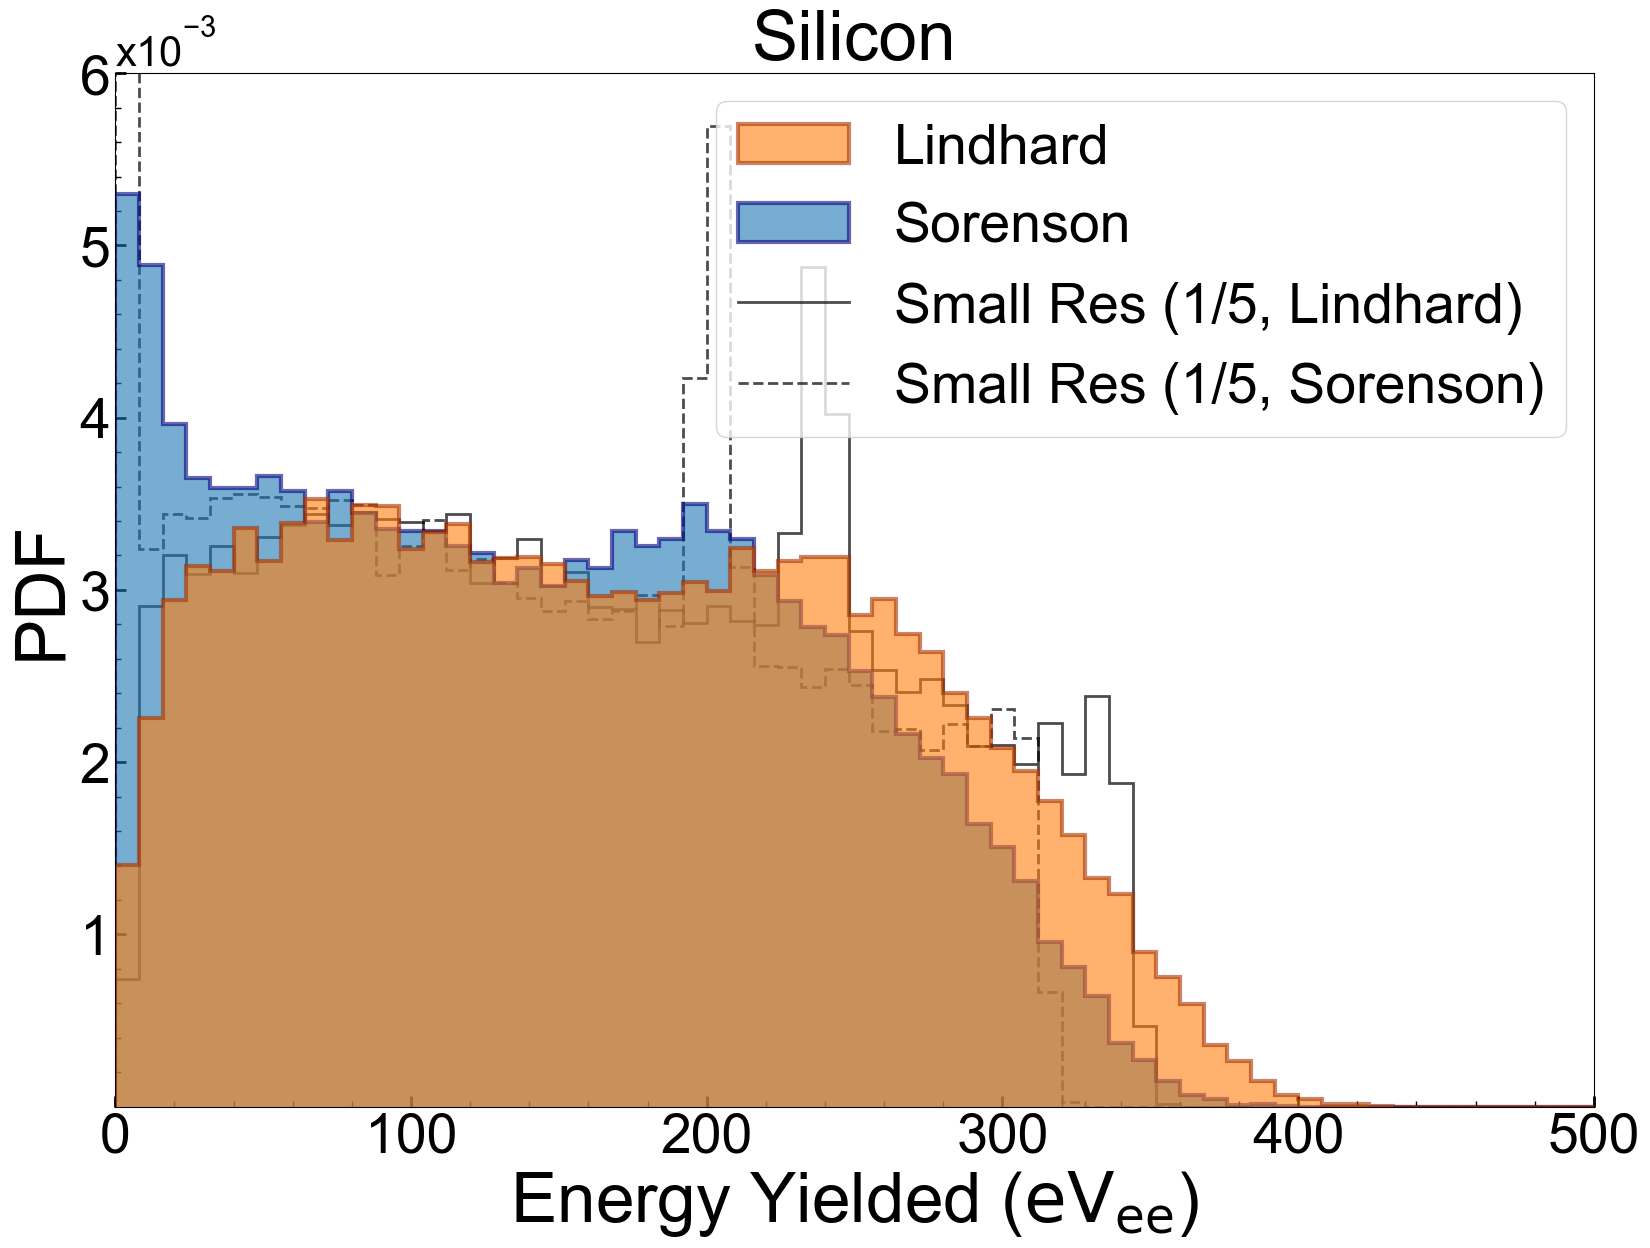

In [9]:
#Plotting!

#Set up to plot
fig, ax = plt.subplots(figsize=(16,12))

#Set up histogram binning.
binsize = 8 #bin width in eVee
bins = np.arange(0,620,binsize)

#Plot data
plt.hist(small_Lind,alpha=0.7,label='Small Res (1/5, Lindhard)',histtype='step',edgecolor='black',density='True',linewidth=2,bins=bins)
plt.hist(small_Sor,alpha=0.7,label='Small Res (1/5, Sorenson)',histtype='step',edgecolor='black',linestyle='--',density='True',linewidth=2,bins=bins)
plt.hist(real_Sor,alpha=0.6,label='Sorenson',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='navy',color='C0')
plt.hist(real_Lind,alpha=0.6,label='Lindhard',histtype='step',fill=True,density='True',bins=bins,linewidth=3,edgecolor='#a30',color='C1')

#Label Axes
plt.xlabel(r"Energy Yielded ($\mathrm{eV}_{\mathrm{ee}}$)",fontsize=50)
plt.ylabel("PDF",fontsize=50)#Counts/(total counts * bin width)")

#Format axis ticks
ax = format_exponent(ax, axis='y')
ax.tick_params(axis='both',which='major',labelsize=40)

#Define plotting region
plt.xlim([0,500])
plt.ylim([6e-13,6e-3]) #Make corner less awkward. Smallest starting value that will make the extra 0 go away

#Legend Formatting
LindPatch = mpatch.Patch(facecolor='C1',edgecolor='#a30',linewidth=3,label='Lindhard',alpha=0.6)
SorPatch = mpatch.Patch(facecolor='C0',edgecolor='navy',linewidth=3,label='Sorenson',alpha=0.6)
LindLine = Line2D([0],[0],alpha=0.7,color='black',label='Small Res (1/5, Lindhard)')
SorLine = Line2D([0],[0],linestyle='--',alpha=0.7,color='black',label='Small Res (1/5, Sorenson)')

#Display everything
plt.legend(handles=[LindPatch,SorPatch,LindLine,SorLine],fontsize=40)
plt.title('Silicon',fontsize=50)
plt.show()